In [21]:
# 1. Transform into 3 images
# 1.1. (C x T) => (3 x 150)
# 1.2. xy, xz, yz and show the temporal evolution => apply CNN (sparse representation)

# 2. Similar idea but with fully connected networks
# 2.1. flatten all => try to predict
# 2.2. 3 x 150 => serve each coordinate to a single perceptron
# 2.3. flatten all => go through latent space (create embeddings) => predict over latent space
# 2.4. 150 x 3 => serve each datapoint to a single perceptron => 150 perceptrons on the first layer

# Normalizare:
# normalizare x, y, z peste dimensiunea temporala => (3,) medii, peste tot datasetu
# normalizare x, y, z separat pentru fiecare moment in parte => (3 x 150) medii, peste tot datasetu

# (f, 1, 1) => for each temporal point
# (t, 1, 1) => all temporal values for one feature
# (1, f, x)

In [22]:
%reload_ext autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import os as so
import numpy as ny
from os import path
import pandas as ps
import pathlib as pb
from typing import List
import matplotlib.pyplot as pt
from modules import processing as pg
from numpy.random import default_rng


# Use GPU if available
so.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [24]:
import tensorflow as tw
from tensorflow import Tensor

# Show warning if running on CPU
available_devices = list(map(lambda d: d.device_type, tw.config.list_physical_devices()))

if 'GPU' not in available_devices:
  print('Available devices = ', tw.config.list_physical_devices())
  print('Warning: running on CPU only')

# Configure the paths to the data files
ROOT_PATH = pb.Path('..')
DATASET_PATH = pb.Path(path.join(ROOT_PATH, 'data'))
DATASET_TEST_PATH = pb.Path(path.join(DATASET_PATH, 'test'))
DATASET_TRAIN_PATH = pb.Path(path.join(DATASET_PATH, 'train'))
DATASET_TRAIN_LABELS_FILEPATH = pb.Path(path.join(DATASET_PATH, 'train_labels.csv'))

In [25]:
# Read train labels raw and use them for lookup
train_labels_lookup = ps.read_csv(DATASET_TRAIN_LABELS_FILEPATH)

# Fetch eatch train sample and do lookup for the corresponding label
train_data = []
train_labels = []
for sample_path in sorted(DATASET_TRAIN_PATH.glob('*.csv')):
  # Lookup the label
  train_label = train_labels_lookup[train_labels_lookup['id'] == int(sample_path.stem)]
  train_labels.append(train_label['class'].item())

  # Read the sample and convert it to a tf compatible format
  train_entry = ps.read_csv(sample_path, header=None, names=['x', 'y', 'z'])
  train_data.append(tw.convert_to_tensor(train_entry))

print('Number of training samples: ', len(train_data))
print('Shape of a training sample: ', train_data[0].shape)

# Read test samples
test_data = []
for sample_path in sorted(DATASET_TEST_PATH.glob('*.csv')):
  test_entry = ps.read_csv(sample_path, header=None, names=['x', 'y', 'z'])
  test_data.append(tw.convert_to_tensor(test_entry))

print('Number of testing samples: ', len(test_data))
print('Shape of a testing sample: ', test_data[0].shape)

Number of training samples:  9000
Shape of a training sample:  (150, 3)
Number of testing samples:  5000
Shape of a testing sample:  (150, 3)


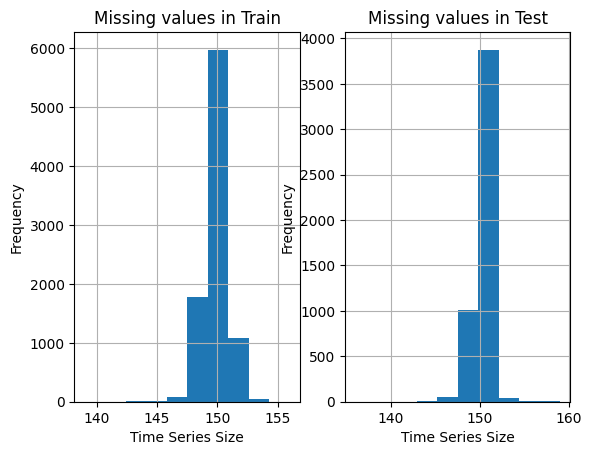

In [26]:
# Compute sizes in order to search for potential missing values in each time series
train_sizes = [sample.shape[0] for sample in train_data]
test_sizes = [sample.shape[0] for sample in test_data]

# Display missing value stats
pt.figure()
for i, (sizes, title) in enumerate([(train_sizes, 'train'), (test_sizes, 'test')]):
  pt.subplot(1, 2, i + 1)
  pt.title(f'Missing values in {title.capitalize()}')
  pt.xlabel('Time Series Size')
  pt.ylabel('Frequency')
  pt.hist(sizes)
  pt.grid(True)

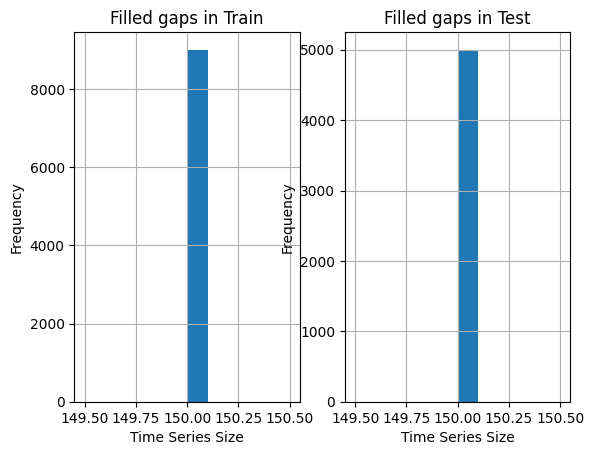

In [27]:
# Fill missing gaps and drop additional points
train_data_proc = pg.fill_missing_values(train_data, 150)
test_data_proc = pg.fill_missing_values(test_data, 150)

# Compute sizes in order to search for potential missing values in each time series
train_sizes = [sample.shape[0] for sample in train_data_proc]
test_sizes = [sample.shape[0] for sample in test_data_proc]

# Display missing value stats
pt.figure()
for i, (sizes, title) in enumerate([(train_sizes, 'train'), (test_sizes, 'test')]):
  pt.subplot(1, 2, i + 1)
  pt.title(f'Filled gaps in {title.capitalize()}')
  pt.xlabel('Time Series Size')
  pt.ylabel('Frequency')
  pt.hist(sizes)
  pt.grid(True)

In [28]:
# Compute the mean and std over the training data across the temporal dimension
train_mean = ny.mean(train_data_proc, axis=(0, 1))
train_std = ny.std(train_data_proc, axis=(0, 1))
print('train_mean = ', train_mean)
print('train_std = ', train_std)

# Scale the features for both training and testing
train_data_norm = (train_data_proc - train_mean) / train_std
test_data_norm = (test_data_proc - train_mean) / train_std

# Reshape the input for the network
train_data_in = tw.expand_dims(train_data_norm, axis=1)
test_data_in = tw.expand_dims(test_data_norm, axis=1)

# Map test labels to [0, 19] and encode them using one-hot
train_labels_out = ny.array(train_labels) - 1
train_labels_one_hot = tw.raw_ops.OneHot(indices=train_labels_out, depth=20, on_value=1.0, off_value=0.0)

train_mean =  [-0.21518754  4.73168209  8.0179037 ]
train_std =  [0.83533816 1.20544209 1.06085183]


In [37]:
from nvitop.callbacks.keras import GpuStatsLogger
from tensorflow.keras.optimizers import Adam
from typing import TypedDict, Callable

class TrainParams(TypedDict):
  n_folds: int
  n_batch: int
  n_epochs: int

class TCNNParams(TypedDict):
  optim: Callable[[], tw.keras.optimizers.Optimizer]
  activ_fn: str
  n_filters: int
  dropout: float
  n_units: int

def create_tcnn_model(hparams: TCNNParams) -> tw.keras.Model:
  model_tcnn = tw.keras.Sequential([
    tw.keras.layers.InputLayer(input_shape=(1, 150, 3)),
    tw.keras.layers.Conv2D(hparams['n_filters'], kernel_size=(1, 10), padding='same', activation=hparams['activ_fn']),
    tw.keras.layers.Dropout(hparams['dropout']),
    tw.keras.layers.Conv2D(hparams['n_filters'], kernel_size=(1, 10), padding='same', activation=hparams['activ_fn']),
    tw.keras.layers.MaxPool2D(pool_size=(1, 3), strides=(1, 2), padding='same'),
    tw.keras.layers.Conv2D(hparams['n_filters'] * 2, kernel_size=(1, 10), padding='same', activation=hparams['activ_fn']),
    tw.keras.layers.Dropout(hparams['dropout']),
    tw.keras.layers.Conv2D(hparams['n_filters'] * 2, kernel_size=(1, 10), padding='same', activation=hparams['activ_fn']),
    tw.keras.layers.MaxPool2D(pool_size=(1, 3), strides=(1, 2), padding='same'),
    tw.keras.layers.Conv2D(hparams['n_filters'] * 4, kernel_size=(1, 10), padding='same', activation=hparams['activ_fn']),
    tw.keras.layers.Dropout(hparams['dropout']),
    tw.keras.layers.Conv2D(hparams['n_filters'] * 4, kernel_size=(1, 10), padding='same', activation=hparams['activ_fn']),
    tw.keras.layers.MaxPool2D(pool_size=(1, 3), strides=(1, 2), padding='same'),
    tw.keras.layers.Flatten(),
    tw.keras.layers.Dense(hparams['n_units'], hparams['activ_fn']),
    tw.keras.layers.Dropout(hparams['dropout']),
    tw.keras.layers.Dense(hparams['n_units'] * 2, hparams['activ_fn']),
    tw.keras.layers.Dropout(hparams['dropout']),
    tw.keras.layers.Dense(hparams['n_units'] * 2, hparams['activ_fn']),
    tw.keras.layers.Dropout(hparams['dropout']),
    tw.keras.layers.Dense(hparams['n_units'] * 2, hparams['activ_fn']),
    tw.keras.layers.Dense(20, 'softmax')
  ], name='TCNN')

  model_tcnn.compile(optimizer=hparams['optim'](),
                    metrics=['categorical_accuracy'],
                    loss='categorical_crossentropy')

  return model_tcnn

def epoch_graph_callback() -> tw.keras.callbacks.Callback:
  return tw.keras.callbacks.TensorBoard(log_dir=ROOT_PATH / 'logs',
                                        write_graph=True)

def gpu_utiliz_callback() -> tw.keras.callbacks.Callback:
  return GpuStatsLogger(['/gpu:0'], memory_utilization=True, gpu_utilization=True)

def fitting_callbacks() -> List[tw.keras.callbacks.Callback]:
  return [
    epoch_graph_callback(),
    gpu_utiliz_callback(),
  ]

Epoch 1/200


2022-11-22 03:15:21.960311: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inTCNN/dropout_78/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


15/15 [==============================] - 3s 50ms/step - loss: 2.9117 - categorical_accuracy: 0.0639 - gpu_id: 0/utilization.memory (%): 24.0000 - gpu_id: 0/utilization.gpu (%): 97.0000 - gpu_id: 0/memory.used (MiB): 23884.0000 - gpu_id: 0/memory.free (MiB): 337.8125 - val_loss: 2.7958 - val_categorical_accuracy: 0.0967
Epoch 2/200
15/15 [==============================] - 0s 17ms/step - loss: 2.6793 - categorical_accuracy: 0.1032 - gpu_id: 0/utilization.memory (%): 24.0000 - gpu_id: 0/utilization.gpu (%): 97.0000 - gpu_id: 0/memory.used (MiB): 23884.0000 - gpu_id: 0/memory.free (MiB): 337.8125 - val_loss: 2.5989 - val_categorical_accuracy: 0.1589
Epoch 3/200
15/15 [==============================] - 0s 8ms/step - loss: 2.4243 - categorical_accuracy: 0.1650 - gpu_id: 0/utilization.memory (%): 8.0000 - gpu_id: 0/utilization.gpu (%): 98.0000 - gpu_id: 0/memory.used (MiB): 23902.0000 - gpu_id: 0/memory.free (MiB): 319.8125 - val_loss: 2.2354 - val_categorical_accuracy: 0.2478
Epoch 4/200
15/

2022-11-22 03:16:06.567280: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inTCNN/dropout_84/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


15/15 [==============================] - 2s 15ms/step - loss: 2.8801 - categorical_accuracy: 0.0547 - gpu_id: 0/utilization.memory (%): 8.0000 - gpu_id: 0/utilization.gpu (%): 59.0000 - gpu_id: 0/memory.used (MiB): 23631.3750 - gpu_id: 0/memory.free (MiB): 590.4375 - val_loss: 2.7369 - val_categorical_accuracy: 0.1178
Epoch 2/200
15/15 [==============================] - 0s 16ms/step - loss: 2.5814 - categorical_accuracy: 0.1214 - gpu_id: 0/utilization.memory (%): 8.0000 - gpu_id: 0/utilization.gpu (%): 59.0000 - gpu_id: 0/memory.used (MiB): 23631.3750 - gpu_id: 0/memory.free (MiB): 590.4375 - val_loss: 2.4981 - val_categorical_accuracy: 0.0994
Epoch 3/200
15/15 [==============================] - 0s 11ms/step - loss: 2.3507 - categorical_accuracy: 0.1696 - gpu_id: 0/utilization.memory (%): 8.0000 - gpu_id: 0/utilization.gpu (%): 59.0000 - gpu_id: 0/memory.used (MiB): 23631.3750 - gpu_id: 0/memory.free (MiB): 590.4375 - val_loss: 2.2535 - val_categorical_accuracy: 0.2028
Epoch 4/200
15/1

2022-11-22 03:16:46.279623: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inTCNN/dropout_90/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


15/15 [==============================] - 2s 15ms/step - loss: 2.9588 - categorical_accuracy: 0.0750 - gpu_id: 0/utilization.memory (%): 5.0000 - gpu_id: 0/utilization.gpu (%): 95.0000 - gpu_id: 0/memory.used (MiB): 24015.8750 - gpu_id: 0/memory.free (MiB): 205.9375 - val_loss: 2.8751 - val_categorical_accuracy: 0.1117
Epoch 2/200
15/15 [==============================] - 0s 9ms/step - loss: 2.6003 - categorical_accuracy: 0.1315 - gpu_id: 0/utilization.memory (%): 5.0000 - gpu_id: 0/utilization.gpu (%): 95.0000 - gpu_id: 0/memory.used (MiB): 24015.8750 - gpu_id: 0/memory.free (MiB): 205.9375 - val_loss: 2.3088 - val_categorical_accuracy: 0.1867
Epoch 3/200
15/15 [==============================] - 0s 8ms/step - loss: 2.0867 - categorical_accuracy: 0.2121 - gpu_id: 0/utilization.memory (%): 5.0000 - gpu_id: 0/utilization.gpu (%): 95.0000 - gpu_id: 0/memory.used (MiB): 24015.8750 - gpu_id: 0/memory.free (MiB): 205.9375 - val_loss: 1.8954 - val_categorical_accuracy: 0.3217
Epoch 4/200
15/15 

2022-11-22 03:17:22.438454: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inTCNN/dropout_96/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


15/15 [==============================] - 2s 21ms/step - loss: 2.9372 - categorical_accuracy: 0.0529 - gpu_id: 0/utilization.memory (%): 7.0000 - gpu_id: 0/utilization.gpu (%): 84.0000 - gpu_id: 0/memory.used (MiB): 23662.7500 - gpu_id: 0/memory.free (MiB): 559.0625 - val_loss: 2.8640 - val_categorical_accuracy: 0.0694
Epoch 2/200
15/15 [==============================] - 0s 11ms/step - loss: 2.6784 - categorical_accuracy: 0.1081 - gpu_id: 0/utilization.memory (%): 7.0000 - gpu_id: 0/utilization.gpu (%): 84.0000 - gpu_id: 0/memory.used (MiB): 23662.7500 - gpu_id: 0/memory.free (MiB): 559.0625 - val_loss: 2.5564 - val_categorical_accuracy: 0.1461
Epoch 3/200
15/15 [==============================] - 0s 7ms/step - loss: 2.3621 - categorical_accuracy: 0.1817 - gpu_id: 0/utilization.memory (%): 7.0000 - gpu_id: 0/utilization.gpu (%): 84.0000 - gpu_id: 0/memory.used (MiB): 23662.7500 - gpu_id: 0/memory.free (MiB): 559.0625 - val_loss: 2.2578 - val_categorical_accuracy: 0.2750
Epoch 4/200
15/15

2022-11-22 03:17:56.051776: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inTCNN/dropout_102/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


15/15 [==============================] - 2s 17ms/step - loss: 2.9623 - categorical_accuracy: 0.0539 - gpu_id: 0/utilization.memory (%): 9.0000 - gpu_id: 0/utilization.gpu (%): 36.0000 - gpu_id: 0/memory.used (MiB): 23757.8750 - gpu_id: 0/memory.free (MiB): 463.9375 - val_loss: 2.9147 - val_categorical_accuracy: 0.0756
Epoch 2/200
15/15 [==============================] - 0s 8ms/step - loss: 2.8120 - categorical_accuracy: 0.0763 - gpu_id: 0/utilization.memory (%): 9.0000 - gpu_id: 0/utilization.gpu (%): 36.0000 - gpu_id: 0/memory.used (MiB): 23757.8750 - gpu_id: 0/memory.free (MiB): 463.9375 - val_loss: 2.7001 - val_categorical_accuracy: 0.1750
Epoch 3/200
15/15 [==============================] - 0s 8ms/step - loss: 2.5247 - categorical_accuracy: 0.1914 - gpu_id: 0/utilization.memory (%): 9.0000 - gpu_id: 0/utilization.gpu (%): 36.0000 - gpu_id: 0/memory.used (MiB): 23757.8750 - gpu_id: 0/memory.free (MiB): 463.9375 - val_loss: 2.2491 - val_categorical_accuracy: 0.2339
Epoch 4/200
15/15 

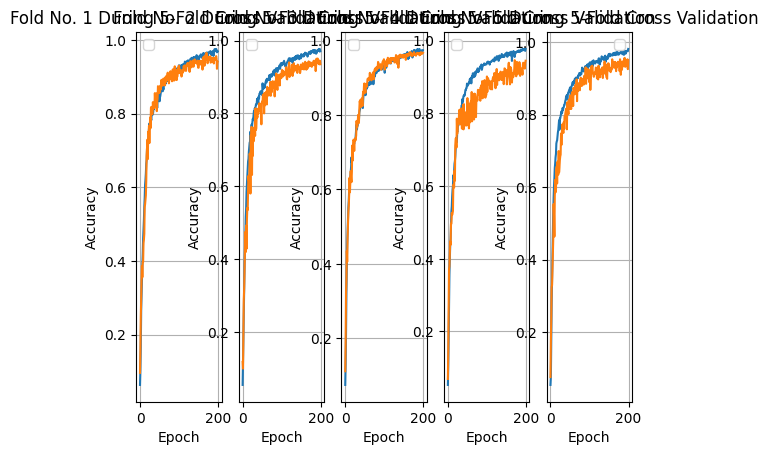

mean_val_loss = 0.17570063918828965
mean_val_accy = 0.9474444389343262
mean_trn_loss = 0.07085335552692414
mean_trn_accy = 0.9744166612625123


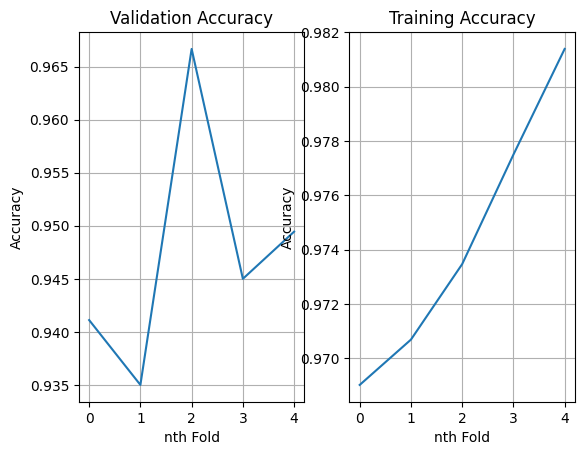

In [38]:
from sklearn.model_selection import KFold

# Display periodic plots across each fold
pt.figure()

# Reformat to sklearn compatible format
train_samples_ny = train_data_in.numpy().reshape(train_data_in.numpy().shape[0], -1)
train_labels_ny = ny.expand_dims(ny.array(train_labels), axis=1)

# Configure t_loop and model hparams
tparams: TrainParams = {
  'n_folds': 5,
  'n_batch': 512,
  'n_epochs': 200,
}
hparams: TCNNParams = {
  'optim': lambda: Adam(learning_rate=2e-4, weight_decay=3e-5),
  'activ_fn': 'relu',
  'n_filters': 16,
  'n_units': 256,
  'dropout': 0.2,
}

# Train and validate using crossvalidation technique
val_accy, val_loss = [], []
trn_accy, trn_loss = [], []
for i, (fold_train, fold_valid) in enumerate(KFold(shuffle=True, n_splits=tparams['n_folds']).split(train_samples_ny, train_labels_ny)):
  # Show progress for each fold
  pt.subplot(1, tparams['n_folds'], i + 1)
  pt.title(f'Fold No. {i + 1} During {tparams["n_folds"]}-Fold Cross Validation')
  pt.legend(['train_accy', 'valid_accy'])
  pt.ylabel('Accuracy')
  pt.xlabel('Epoch')
  pt.grid(True)

  # Transform points into compatible integer indices
  fold_train, fold_valid = tw.convert_to_tensor(fold_train, dtype=tw.int32), \
                           tw.convert_to_tensor(fold_valid, dtype=tw.int32)

  # Create new model with random weights
  model_tcnn = create_tcnn_model(hparams)

  # Gather points for each step
  train_samples_fold = tw.gather(train_data_in, fold_train)
  valid_samples_fold = tw.gather(train_data_in, fold_valid)
  train_labels_fold = tw.gather(train_labels_one_hot, fold_train)
  valid_labels_fold = tw.gather(train_labels_one_hot, fold_valid)

  # Learn on training data and predict on valid set
  fold_history = model_tcnn.fit(train_samples_fold, train_labels_fold,
                 validation_data=(valid_samples_fold, valid_labels_fold),
                 batch_size=tparams['n_batch'], epochs=tparams['n_epochs'],
                 workers=8, use_multiprocessing=True, initial_epoch=0,
                 callbacks=fitting_callbacks())

  # Save max valid & train accy for the current fold
  val_accy.append(fold_history.history['val_categorical_accuracy'][-1])
  val_loss.append(fold_history.history['val_loss'][-1])
  trn_accy.append(fold_history.history['categorical_accuracy'][-1])
  trn_loss.append(fold_history.history['loss'][-1])

  # Display fold results
  pt.plot(ny.arange(tparams['n_epochs']), fold_history.history['categorical_accuracy'])
  pt.plot(ny.arange(tparams['n_epochs']), fold_history.history['val_categorical_accuracy'])

# Show results across all folds
pt.show()
pt.figure()
print(f'mean_val_loss = {ny.mean(val_loss)}')
print(f'mean_val_accy = {ny.mean(val_accy)}')
print(f'mean_trn_loss = {ny.mean(trn_loss)}')
print(f'mean_trn_accy = {ny.mean(trn_accy)}')

# Show val across folds
pt.subplot(1, 2, 1)
pt.grid(True)
pt.xlabel('nth Fold')
pt.ylabel('Accuracy')
pt.title('Validation Accuracy')
pt.plot(ny.arange(tparams['n_folds']), val_accy)

# Show train across folds
pt.subplot(1, 2, 2)
pt.grid(True)
pt.xlabel('nth Fold')
pt.ylabel('Accuracy')
pt.title('Training Accuracy')
pt.plot(ny.arange(tparams['n_folds']), trn_accy)
pt.show()

Epoch 1/200


2022-11-22 03:19:16.454240: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inTCNN/dropout_108/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


14/14 [==============================] - 2s 53ms/step - loss: 2.9181 - categorical_accuracy: 0.0523
Epoch 2/200
14/14 [==============================] - 0s 6ms/step - loss: 2.6962 - categorical_accuracy: 0.0991
Epoch 3/200
14/14 [==============================] - 0s 6ms/step - loss: 2.5357 - categorical_accuracy: 0.1161
Epoch 4/200
14/14 [==============================] - 0s 13ms/step - loss: 2.4130 - categorical_accuracy: 0.1414
Epoch 5/200
14/14 [==============================] - 0s 6ms/step - loss: 2.2263 - categorical_accuracy: 0.2421
Epoch 6/200
14/14 [==============================] - 0s 6ms/step - loss: 1.9466 - categorical_accuracy: 0.3047
Epoch 7/200
14/14 [==============================] - 0s 6ms/step - loss: 1.6891 - categorical_accuracy: 0.3643
Epoch 8/200
14/14 [==============================] - 0s 7ms/step - loss: 1.5383 - categorical_accuracy: 0.4050
Epoch 9/200
14/14 [==============================] - 0s 12ms/step - loss: 1.4084 - categorical_accuracy: 0.4457
Epoch 10/2

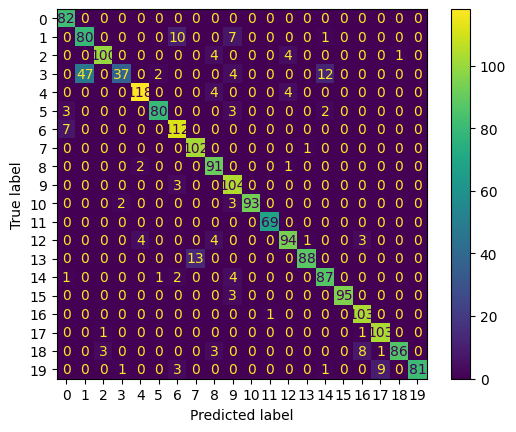

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Recreate model to train from scratch for subtask
model_tcnn = create_tcnn_model(hparams)

# Split data indices
n_subset_valid = 2_000
n_subset_train_i = train_data_in.shape[0] - n_subset_valid
n_subset_valid_i = n_subset_train_i

# Fit model on all training data except last 2_000 entries
model_tcnn.fit(train_data_in[:n_subset_train_i], train_labels_one_hot[:n_subset_train_i],
               batch_size=tparams['n_batch'], epochs=tparams['n_epochs'],
               initial_epoch=0, workers=8, use_multiprocessing=True)

# Predict on last 2_000 entries
y_pred = model_tcnn.predict(train_data_in[n_subset_valid_i:])

# Transform back to labels instead of probs
y_pred_labels = ny.argmax(y_pred, axis=1)
y_grnd_labels = ny.argmax(train_labels_one_hot[n_subset_valid_i:], axis=1)
m_cnf = confusion_matrix(y_grnd_labels, y_pred_labels)
ConfusionMatrixDisplay(m_cnf).plot()
pt.show()

In [40]:
# Instantiate model for final prediction on test set
model_tcnn = create_tcnn_model(hparams)

# Fit on the entire training to have more data for further predictions
model_tcnn.fit(train_data_in, train_labels_one_hot,
               batch_size=tparams['n_batch'], epochs=tparams['n_epochs'],
               initial_epoch=0, workers=8, use_multiprocessing=True)

# Predict unknown labels
test_pred_probs = model_tcnn.predict(test_data_in, batch_size=tparams['n_batch'],
                                      workers=8, use_multiprocessing=True)
test_pred_labels = ny.argmax(test_pred_probs, axis=1) + 1 # [0, 19] -> [1, 20]

Epoch 1/200


2022-11-22 03:19:54.806069: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inTCNN/dropout_114/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - 2s 44ms/step - loss: 2.8725 - categorical_accuracy: 0.0563
Epoch 2/200
18/18 [==============================] - 0s 6ms/step - loss: 2.6855 - categorical_accuracy: 0.1060
Epoch 3/200
18/18 [==============================] - 0s 6ms/step - loss: 2.4599 - categorical_accuracy: 0.1594
Epoch 4/200
18/18 [==============================] - 0s 6ms/step - loss: 2.1279 - categorical_accuracy: 0.2274
Epoch 5/200
18/18 [==============================] - 0s 11ms/step - loss: 1.9484 - categorical_accuracy: 0.2834
Epoch 6/200
18/18 [==============================] - 0s 6ms/step - loss: 1.8167 - categorical_accuracy: 0.3246
Epoch 7/200
18/18 [==============================] - 0s 6ms/step - loss: 1.7004 - categorical_accuracy: 0.3619
Epoch 8/200
18/18 [==============================] - 0s 6ms/step - loss: 1.5854 - categorical_accuracy: 0.4001
Epoch 9/200
18/18 [==============================] - 0s 11ms/step - loss: 1.4311 - categorical_accuracy: 0.4731
Epoch 10/2

In [41]:
# Create resulting test object
test_ids = ps.Series([p.stem for p in sorted(DATASET_TEST_PATH.glob('*.csv'))], name='id')
test_classes = ps.Series(test_pred_labels, name='class')
test_results = ps.DataFrame({
  'id': test_ids,
  'class': test_classes,
})

# And store the results obtained by the model using that previously created test frame
test_results.to_csv(DATASET_PATH / 'test_labels_4.csv', mode='w', header=True, index=False)